<a href="https://colab.research.google.com/github/rtajeong/M4_2025/blob/main/lab_93_CGAN_with_fashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditional GAN with fashion-MNIST
- https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Input
from tensorflow.keras.layers import Conv2DTranspose, LeakyReLU, Dropout
from tensorflow.keras.layers import Embedding, Concatenate
from tensorflow.keras.utils import to_categorical

In [ ]:
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()

print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

4422102/4422102 [==============================] - 1s 0us/step
Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


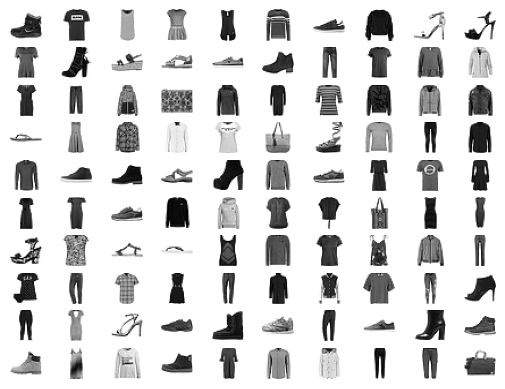

In [ ]:
for i in range(100):
	plt.subplot(10, 10, 1 + i)
	plt.axis('off')
	plt.imshow(trainX[i], cmap='gray_r')  # cmap = gray or gray_r
plt.show()

In [ ]:
set(trainy)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

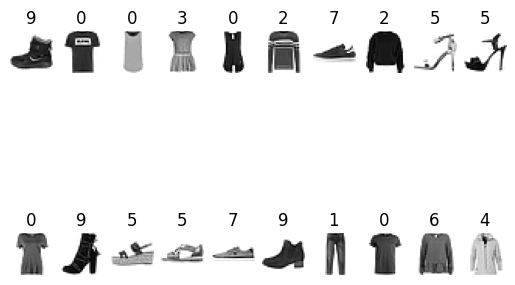

In [ ]:
for i in range(20):
    plt.subplot(2, 10, 1 + i)
    plt.axis('off')
    plt.imshow(trainX[i], cmap='gray_r')  # cmap = gray or gray_r
    plt.title(trainy[i])
plt.show()

- 0(t-shirt), 1(trouser), 2(pullover), 3(dress), 4(coat), 5(sandal), 6(shirt), 7(
sneaker), 8(bag), 9(ankle boot)

## Conditional GAN
- input: it takes additional information (labels, classes, etc.) as input along with random noise.
- output: it generates data samples conditioned on the provided information.
- objective: to generate data samples that not only resemble real data but also satisfy specific conditions provided as input.
- There are many ways to represent the class for cGAN, and the most widely used one is one-hot encoding and integer encoding. Here we use an Embedding layer to convert the classes into 50-dim vectors.
- We will use the functional API to re-implement the discriminator, generator, and the composite model.

- discriminator
  - a new second input is defined that takes an integer for the class label of the image. This has the effect of making the input image conditional on the provided class label.
  - The class label is then passed through an Embedding layer with the size of 50. This means that each of the 10 classes for the Fashion MNIST dataset (0 through 9) will map to a different 50-element vector representation that will be learned by the discriminator model.
- generator
  - must be updated to take the class label. This has the effect of making the point in the latent space conditional on the provided class label.
  - the class label is passed through an embedding layer to map it to a unique 50-element vector and is then passed through a fully connected layer with a linear activation before being resized.
  - The new 7×7 feature map is added as one more channel to the existing 128, resulting in 129 feature maps that are then upsampled as in the prior model.

In [ ]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):

	in_label = Input(shape=(1,))              # (class) label input
	li = Embedding(n_classes, 50)(in_label)   # embedding for categorical class input
	n_nodes = in_shape[0] * in_shape[1]       # no of flattened nodes
	li = Dense(n_nodes)(li)
	li = Reshape((in_shape[0], in_shape[1], 1))(li)  # reshape to additional channel

	in_image = Input(shape=in_shape)          # image input
	merge = Concatenate()([in_image, li])     # concat image with label

	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Flatten()(fe)
	fe = Dropout(0.4)(fe)
	out_layer = Dense(1, activation='sigmoid')(fe)

	model = Model([in_image, in_label], out_layer)
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 50)                500       ['input_1[0][0]']             
                                                                                                  
 dense (Dense)               (None, 1, 784)               39984     ['embedding[0][0]']           
                                                                                                  
 input_2 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                              

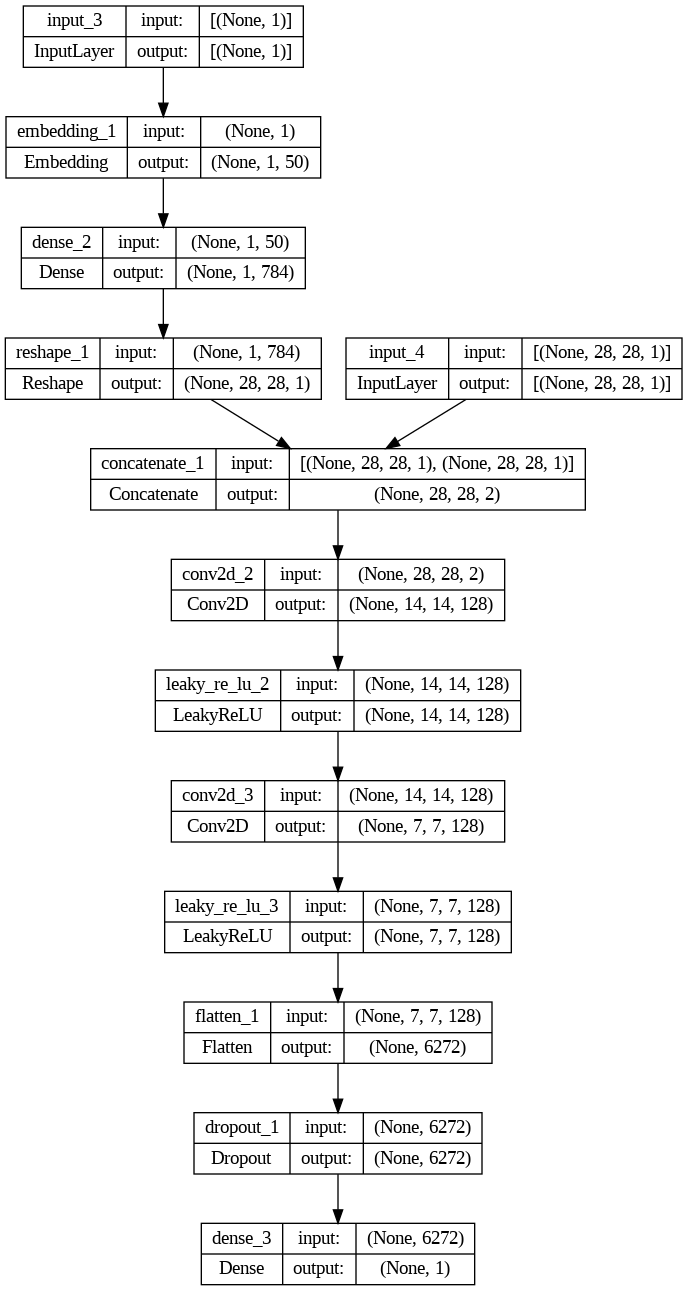

In [ ]:
define_discriminator().summary()
keras.utils.plot_model(define_discriminator(), "cgan_encoder.png", show_shapes=True)

- As in the discriminator, the class label is passed through an embedding layer to map it to a unique 50-element vector and is then passed through a fully connected layer with a linear activation before being resized.
- In this case, the activations of the fully connected layer are resized into a single 7×7 feature map. This is to match the 7×7 feature map activations of the unconditional generator model.
- The new 7×7 feature map is added as one more channel to the existing 128, resulting in 129 feature maps that are then upsampled as in the prior model.

In [ ]:
# define the standalone generator model
def define_generator(latent_dim, n_classes=10):

	in_label = Input(shape=(1,))            # label input
	li = Embedding(n_classes, 50)(in_label) # embedding for categorical input
	li = Dense(7 * 7)(li)                   # linear multiplication
	li = Reshape((7, 7, 1))(li)

	in_lat = Input(shape=(latent_dim,))     # image generator input
	n_nodes = 128 * 7 * 7                   # foundation for 7x7 image
	gen = Dense(n_nodes)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((7, 7, 128))(gen)

	merge = Concatenate()([gen, li])        # merge image gen and label input
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge) # upsample to 14x14
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)   # upsample to 28x28
	gen = LeakyReLU(alpha=0.2)(gen)
	out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)

	model = Model([in_lat, in_label], out_layer)
	return model

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 100)]                0         []                            
                                                                                                  
 input_9 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 dense_9 (Dense)             (None, 6272)                 633472    ['input_10[0][0]']            
                                                                                                  
 embedding_4 (Embedding)     (None, 1, 50)                500       ['input_9[0][0]']             
                                                                                            

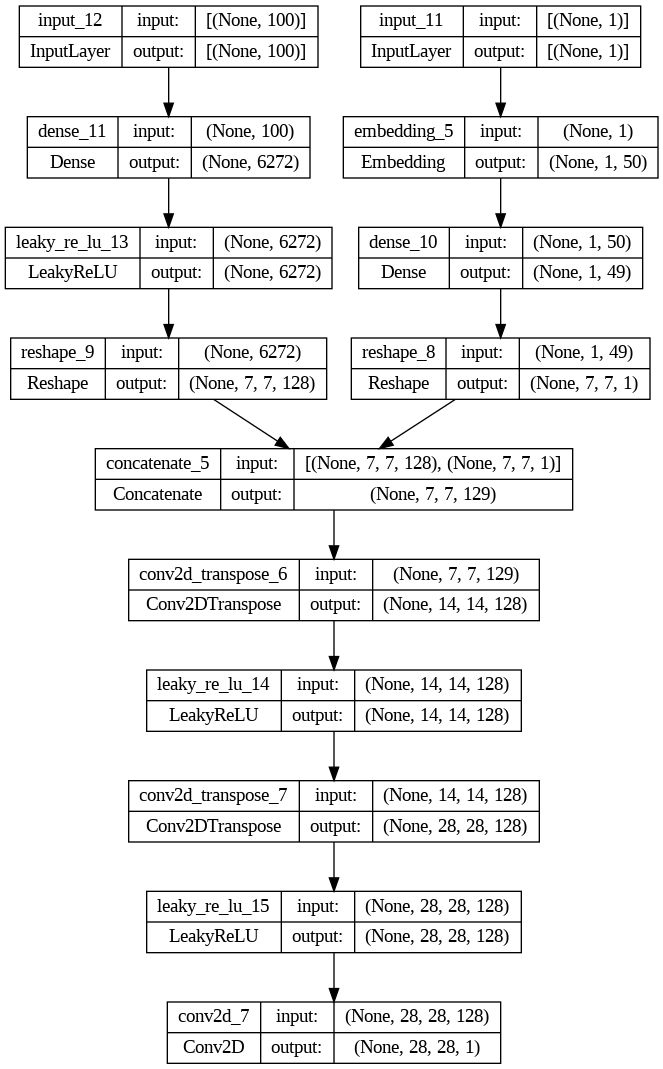

In [ ]:
define_generator(100).summary()
keras.utils.plot_model(define_generator(100), "cgan_encoder.png", show_shapes=True)

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):

	d_model.trainable = False
	# get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input
	# get image output from the generator model
	gen_output = g_model.output
	# connect image output and label input from generator as inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)

	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_18 (InputLayer)       [(None, 100)]                0         []                            
                                                                                                  
 input_17 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 dense_17 (Dense)            (None, 6272)                 633472    ['input_18[0][0]']            
                                                                                                  
 embedding_8 (Embedding)     (None, 1, 50)                500       ['input_17[0][0]']            
                                                                                           

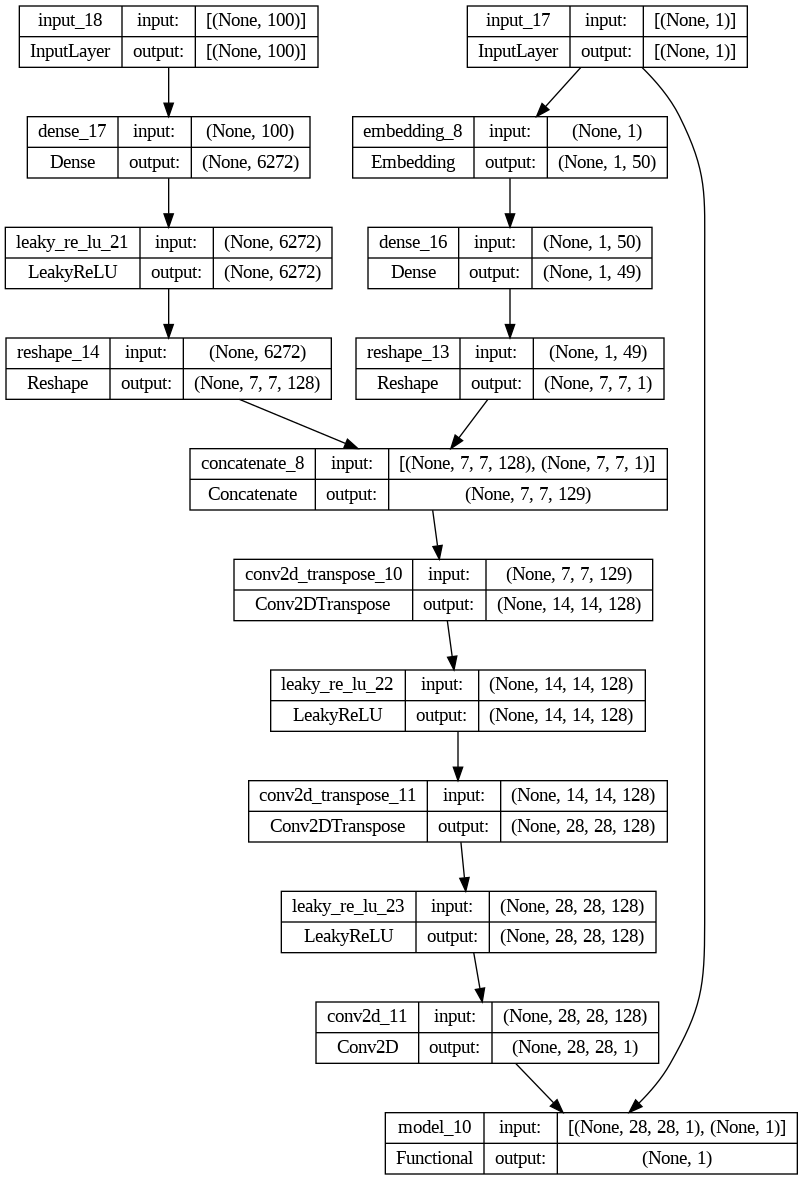

In [ ]:
all = define_gan(define_generator(100), define_discriminator())
all.summary()
keras.utils.plot_model(all, "all.png", show_shapes=True)

In [ ]:
# load fashion mnist images
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = fashion_mnist.load_data()
	# expand to 3d, e.g. add channels
	X = np.expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return [X, trainy]

# select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = np.random.randint(0, images.shape[0], n_samples)  # tf does not have randint
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = np.ones((n_samples, 1))
	return [X, labels], y

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = np.random.randint(0, n_classes, n_samples)
	return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = np.zeros((n_samples, 1))
	return [images, labels_input], y

In [ ]:
# train the generator and discriminator
from tqdm import tqdm

def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=128): # n_epochs=100
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in tqdm(range(n_epochs)):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
			# generate 'fake' examples
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
			# prepare points in latent space as input for the generator
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = np.ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
	# save the generator model
	g_model.save('cgan_generator.h5')

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

  0%|          | 0/10 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step
>1, 1/468, d1=0.732, d2=0.693 g=0.694
2/2 [==============================] - 0s 4ms/step
>1, 2/468, d1=0.649, d2=0.697 g=0.690
2/2 [==============================] - 0s 5ms/step
>1, 3/468, d1=0.587, d2=0.703 g=0.684
2/2 [==============================] - 0s 4ms/step
>1, 4/468, d1=0.528, d2=0.713 g=0.674
2/2 [==============================] - 0s 5ms/step
>1, 5/468, d1=0.469, d2=0.731 g=0.660
2/2 [==============================] - 0s 4ms/step
>1, 6/468, d1=0.425, d2=0.752 g=0.641
2/2 [==============================] - 0s 4ms/step
>1, 7/468, d1=0.375, d2=0.789 g=0.623
2/2 [==============================] - 0s 4ms/step
>1, 8/468, d1=0.344, d2=0.812 g=0.606
2/2 [==============================] - 0s 4ms/step
>1, 9/468, d1=0.301, d2=0.835 g=0.616
2/2 [==============================] - 0s 3ms/step
>1, 10/468, d1=0.311, d2=0.823 g=0.646
2/2 [==============================] - 0s 4ms/step
>1, 11/468, d1=0.309, d2=0.774 g=0.709
2/2 [==============

 10%|█         | 1/10 [01:06<09:58, 66.55s/it]

>1, 468/468, d1=0.679, d2=0.651 g=0.756
2/2 [==============================] - 0s 4ms/step
>2, 1/468, d1=0.670, d2=0.659 g=0.766
2/2 [==============================] - 0s 4ms/step
>2, 2/468, d1=0.642, d2=0.692 g=0.755
2/2 [==============================] - 0s 4ms/step
>2, 3/468, d1=0.711, d2=0.687 g=0.739
2/2 [==============================] - 0s 4ms/step
>2, 4/468, d1=0.663, d2=0.742 g=0.731
2/2 [==============================] - 0s 4ms/step
>2, 5/468, d1=0.638, d2=0.697 g=0.728
2/2 [==============================] - 0s 4ms/step
>2, 6/468, d1=0.639, d2=0.682 g=0.735
2/2 [==============================] - 0s 4ms/step
>2, 7/468, d1=0.666, d2=0.728 g=0.738
2/2 [==============================] - 0s 4ms/step
>2, 8/468, d1=0.671, d2=0.721 g=0.742
2/2 [==============================] - 0s 4ms/step
>2, 9/468, d1=0.684, d2=0.672 g=0.769
2/2 [==============================] - 0s 4ms/step
>2, 10/468, d1=0.688, d2=0.652 g=0.767
2/2 [==============================] - 0s 4ms/step
>2, 11/468, d1=0.6

 20%|██        | 2/10 [02:02<08:04, 60.54s/it]

>2, 468/468, d1=0.649, d2=0.636 g=0.804
2/2 [==============================] - 0s 4ms/step
>3, 1/468, d1=0.656, d2=0.649 g=0.792
2/2 [==============================] - 0s 4ms/step
>3, 2/468, d1=0.670, d2=0.663 g=0.782
2/2 [==============================] - 0s 4ms/step
>3, 3/468, d1=0.607, d2=0.660 g=0.744
2/2 [==============================] - 0s 4ms/step
>3, 4/468, d1=0.658, d2=0.695 g=0.736
2/2 [==============================] - 0s 4ms/step
>3, 5/468, d1=0.612, d2=0.706 g=0.720
2/2 [==============================] - 0s 4ms/step
>3, 6/468, d1=0.696, d2=0.743 g=0.709
2/2 [==============================] - 0s 4ms/step
>3, 7/468, d1=0.675, d2=0.721 g=0.727
2/2 [==============================] - 0s 4ms/step
>3, 8/468, d1=0.693, d2=0.726 g=0.733
2/2 [==============================] - 0s 4ms/step
>3, 9/468, d1=0.688, d2=0.710 g=0.764
2/2 [==============================] - 0s 4ms/step
>3, 10/468, d1=0.662, d2=0.702 g=0.779
2/2 [==============================] - 0s 5ms/step
>3, 11/468, d1=0.6

 30%|███       | 3/10 [03:00<06:54, 59.17s/it]

>3, 468/468, d1=0.647, d2=0.706 g=0.781
2/2 [==============================] - 0s 5ms/step
>4, 1/468, d1=0.662, d2=0.683 g=0.768
2/2 [==============================] - 0s 4ms/step
>4, 2/468, d1=0.640, d2=0.654 g=0.762
2/2 [==============================] - 0s 4ms/step
>4, 3/468, d1=0.666, d2=0.664 g=0.774
2/2 [==============================] - 0s 4ms/step
>4, 4/468, d1=0.680, d2=0.657 g=0.806
2/2 [==============================] - 0s 5ms/step
>4, 5/468, d1=0.698, d2=0.645 g=0.820
2/2 [==============================] - 0s 4ms/step
>4, 6/468, d1=0.695, d2=0.611 g=0.818
2/2 [==============================] - 0s 5ms/step
>4, 7/468, d1=0.679, d2=0.603 g=0.842
2/2 [==============================] - 0s 4ms/step
>4, 8/468, d1=0.677, d2=0.592 g=0.866
2/2 [==============================] - 0s 5ms/step
>4, 9/468, d1=0.686, d2=0.611 g=0.853
2/2 [==============================] - 0s 4ms/step
>4, 10/468, d1=0.682, d2=0.627 g=0.813
2/2 [==============================] - 0s 4ms/step
>4, 11/468, d1=0.6

 40%|████      | 4/10 [03:57<05:49, 58.24s/it]

>4, 468/468, d1=0.655, d2=0.662 g=0.793
2/2 [==============================] - 0s 5ms/step
>5, 1/468, d1=0.636, d2=0.689 g=0.750
2/2 [==============================] - 0s 4ms/step
>5, 2/468, d1=0.579, d2=0.707 g=0.740
2/2 [==============================] - 0s 4ms/step
>5, 3/468, d1=0.663, d2=0.714 g=0.758
2/2 [==============================] - 0s 4ms/step
>5, 4/468, d1=0.637, d2=0.691 g=0.734
2/2 [==============================] - 0s 4ms/step
>5, 5/468, d1=0.676, d2=0.685 g=0.767
2/2 [==============================] - 0s 4ms/step
>5, 6/468, d1=0.650, d2=0.670 g=0.794
2/2 [==============================] - 0s 4ms/step
>5, 7/468, d1=0.684, d2=0.641 g=0.837
2/2 [==============================] - 0s 4ms/step
>5, 8/468, d1=0.683, d2=0.604 g=0.861
2/2 [==============================] - 0s 4ms/step
>5, 9/468, d1=0.704, d2=0.601 g=0.881
2/2 [==============================] - 0s 4ms/step
>5, 10/468, d1=0.704, d2=0.591 g=0.857
2/2 [==============================] - 0s 4ms/step
>5, 11/468, d1=0.6

 50%|█████     | 5/10 [04:55<04:50, 58.09s/it]

>5, 468/468, d1=0.635, d2=0.699 g=0.741
2/2 [==============================] - 0s 4ms/step
>6, 1/468, d1=0.649, d2=0.670 g=0.777
2/2 [==============================] - 0s 4ms/step
>6, 2/468, d1=0.660, d2=0.665 g=0.795
2/2 [==============================] - 0s 4ms/step
>6, 3/468, d1=0.673, d2=0.648 g=0.830
2/2 [==============================] - 0s 4ms/step
>6, 4/468, d1=0.654, d2=0.609 g=0.840
2/2 [==============================] - 0s 5ms/step
>6, 5/468, d1=0.662, d2=0.616 g=0.851
2/2 [==============================] - 0s 4ms/step
>6, 6/468, d1=0.677, d2=0.666 g=0.790
2/2 [==============================] - 0s 5ms/step
>6, 7/468, d1=0.673, d2=0.701 g=0.773
2/2 [==============================] - 0s 5ms/step
>6, 8/468, d1=0.704, d2=0.702 g=0.784
2/2 [==============================] - 0s 5ms/step
>6, 9/468, d1=0.710, d2=0.728 g=0.750
2/2 [==============================] - 0s 4ms/step
>6, 10/468, d1=0.707, d2=0.698 g=0.752
2/2 [==============================] - 0s 4ms/step
>6, 11/468, d1=0.7

 60%|██████    | 6/10 [05:52<03:51, 57.81s/it]

>6, 468/468, d1=0.666, d2=0.658 g=0.769
2/2 [==============================] - 0s 5ms/step
>7, 1/468, d1=0.671, d2=0.672 g=0.783
2/2 [==============================] - 0s 4ms/step
>7, 2/468, d1=0.625, d2=0.678 g=0.784
2/2 [==============================] - 0s 5ms/step
>7, 3/468, d1=0.677, d2=0.648 g=0.778
2/2 [==============================] - 0s 4ms/step
>7, 4/468, d1=0.644, d2=0.649 g=0.832
2/2 [==============================] - 0s 4ms/step
>7, 5/468, d1=0.658, d2=0.628 g=0.843
2/2 [==============================] - 0s 5ms/step
>7, 6/468, d1=0.618, d2=0.677 g=0.816
2/2 [==============================] - 0s 4ms/step
>7, 7/468, d1=0.662, d2=0.681 g=0.773
2/2 [==============================] - 0s 4ms/step
>7, 8/468, d1=0.675, d2=0.699 g=0.769
2/2 [==============================] - 0s 4ms/step
>7, 9/468, d1=0.670, d2=0.671 g=0.796
2/2 [==============================] - 0s 4ms/step
>7, 10/468, d1=0.662, d2=0.641 g=0.817
2/2 [==============================] - 0s 4ms/step
>7, 11/468, d1=0.6

 70%|███████   | 7/10 [06:50<02:54, 58.02s/it]

>7, 468/468, d1=0.675, d2=0.678 g=0.751
2/2 [==============================] - 0s 4ms/step
>8, 1/468, d1=0.651, d2=0.658 g=0.770
2/2 [==============================] - 0s 4ms/step
>8, 2/468, d1=0.687, d2=0.660 g=0.765
2/2 [==============================] - 0s 4ms/step
>8, 3/468, d1=0.668, d2=0.654 g=0.782
2/2 [==============================] - 0s 4ms/step
>8, 4/468, d1=0.644, d2=0.659 g=0.798
2/2 [==============================] - 0s 4ms/step
>8, 5/468, d1=0.633, d2=0.649 g=0.758
2/2 [==============================] - 0s 4ms/step
>8, 6/468, d1=0.652, d2=0.702 g=0.745
2/2 [==============================] - 0s 5ms/step
>8, 7/468, d1=0.675, d2=0.696 g=0.746
2/2 [==============================] - 0s 4ms/step
>8, 8/468, d1=0.652, d2=0.677 g=0.722
2/2 [==============================] - 0s 4ms/step
>8, 9/468, d1=0.652, d2=0.687 g=0.775
2/2 [==============================] - 0s 4ms/step
>8, 10/468, d1=0.688, d2=0.676 g=0.816
2/2 [==============================] - 0s 5ms/step
>8, 11/468, d1=0.6

 80%|████████  | 8/10 [07:47<01:55, 57.76s/it]

>8, 468/468, d1=0.644, d2=0.672 g=0.847
2/2 [==============================] - 0s 4ms/step
>9, 1/468, d1=0.663, d2=0.632 g=0.807
2/2 [==============================] - 0s 5ms/step
>9, 2/468, d1=0.698, d2=0.671 g=0.802
2/2 [==============================] - 0s 5ms/step
>9, 3/468, d1=0.654, d2=0.637 g=0.782
2/2 [==============================] - 0s 4ms/step
>9, 4/468, d1=0.632, d2=0.687 g=0.775
2/2 [==============================] - 0s 4ms/step
>9, 5/468, d1=0.656, d2=0.647 g=0.807
2/2 [==============================] - 0s 4ms/step
>9, 6/468, d1=0.670, d2=0.644 g=0.788
2/2 [==============================] - 0s 5ms/step
>9, 7/468, d1=0.636, d2=0.670 g=0.789
2/2 [==============================] - 0s 4ms/step
>9, 8/468, d1=0.675, d2=0.652 g=0.795
2/2 [==============================] - 0s 4ms/step
>9, 9/468, d1=0.674, d2=0.652 g=0.783
2/2 [==============================] - 0s 3ms/step
>9, 10/468, d1=0.682, d2=0.681 g=0.778
2/2 [==============================] - 0s 5ms/step
>9, 11/468, d1=0.6

 90%|█████████ | 9/10 [08:46<00:58, 58.03s/it]

>9, 468/468, d1=0.734, d2=0.665 g=0.775
2/2 [==============================] - 0s 4ms/step
>10, 1/468, d1=0.694, d2=0.659 g=0.802
2/2 [==============================] - 0s 4ms/step
>10, 2/468, d1=0.695, d2=0.693 g=0.766
2/2 [==============================] - 0s 4ms/step
>10, 3/468, d1=0.680, d2=0.673 g=0.758
2/2 [==============================] - 0s 4ms/step
>10, 4/468, d1=0.656, d2=0.677 g=0.775
2/2 [==============================] - 0s 6ms/step
>10, 5/468, d1=0.663, d2=0.632 g=0.792
2/2 [==============================] - 0s 4ms/step
>10, 6/468, d1=0.647, d2=0.661 g=0.818
2/2 [==============================] - 0s 4ms/step
>10, 7/468, d1=0.683, d2=0.674 g=0.759
2/2 [==============================] - 0s 4ms/step
>10, 8/468, d1=0.659, d2=0.672 g=0.758
2/2 [==============================] - 0s 4ms/step
>10, 9/468, d1=0.677, d2=0.688 g=0.762
2/2 [==============================] - 0s 4ms/step
>10, 10/468, d1=0.627, d2=0.633 g=0.774
2/2 [==============================] - 0s 4ms/step
>10, 11/

100%|██████████| 10/10 [09:44<00:00, 58.42s/it]
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


>10, 468/468, d1=0.670, d2=0.646 g=0.770


## conditional clothing generation

In [ ]:
# foir reference
print([x for _ in range(4) for x in range(5)])

[0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4]


In [ ]:
# for reference
X = model.predict([latent_points, labels])
X.shape, X.max(), X.min()

4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 27ms/step


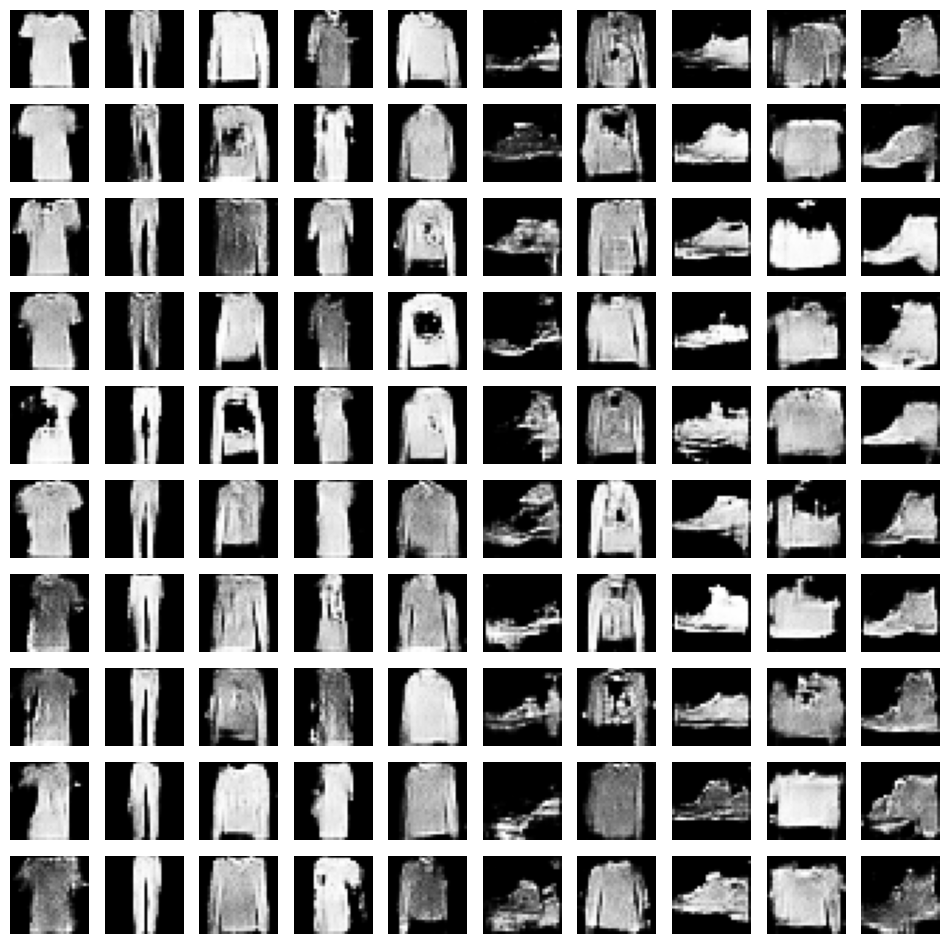

In [ ]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
import matplotlib.pyplot as plt

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	x_input = randn(latent_dim * n_samples)           # generate points in the latent space
	z_input = x_input.reshape(n_samples, latent_dim)  # reshape into a batch of inputs for the network
	labels = randint(0, n_classes, n_samples)         # generate labels
	return [z_input, labels]

# create and save a plot of generated images
def save_plot(examples, n):
	plt.figure(figsize=(12,12))
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		# plt.imshow(examples[i, :, :, 0], cmap='gray_r')
		plt.imshow(examples[i, :, :, 0], cmap='gray')
	plt.show()

# load model
model = load_model('cgan_generator.h5')

latent_points, labels = generate_latent_points(100, 100)
labels = asarray([x for _ in range(10) for x in range(10)])

X  = model.predict([latent_points, labels])  # generate images

X = (X + 1) / 2.0    # scale from [-1,1] to [0,1]

save_plot(X, 10)

- The clothing is organized in columns. From left to right, they are “t-shirt“, ‘trouser‘, ‘pullover‘, ‘dress‘, ‘coat‘, ‘sandal‘, ‘shirt‘, ‘sneaker‘, ‘bag‘, and ‘ankle boot‘.

- We can see not only are the randomly generated items of clothing plausible, but they also match their expected category.

- Compared with a standard GAN, the cGAN's advantage lies in its ability to generate images with specific attributes or characteristics defined by the condition, which can be a powerful feature depending on the application.
- If the conditional information is well-structured and relevant to the generation task, the cGAN can potentially produce images of similar or even better quality compared to a standard GAN.


# Putting altogether
- uses one_hot encoding instead of Embedding layer for target values

In [ ]:
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()

print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


In [ ]:
# define the standalone discriminator model
def define_discriminator2():

	in_label = Input(shape=(10,))
	li = Dense(784)(in_label)
	li = Reshape((28, 28, 1))(li)

	in_image = Input(shape=(28,28,1))
	merge = Concatenate()([in_image, li])

	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Flatten()(fe)
	fe = Dropout(0.4)(fe)
	out_layer = Dense(1, activation='sigmoid')(fe)

	model = Model([in_image, in_label], out_layer)
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

Model: "model_33"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_55 (InputLayer)       [(None, 10)]                 0         []                            
                                                                                                  
 dense_54 (Dense)            (None, 784)                  8624      ['input_55[0][0]']            
                                                                                                  
 input_56 (InputLayer)       [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 reshape_38 (Reshape)        (None, 28, 28, 1)            0         ['dense_54[0][0]']            
                                                                                           

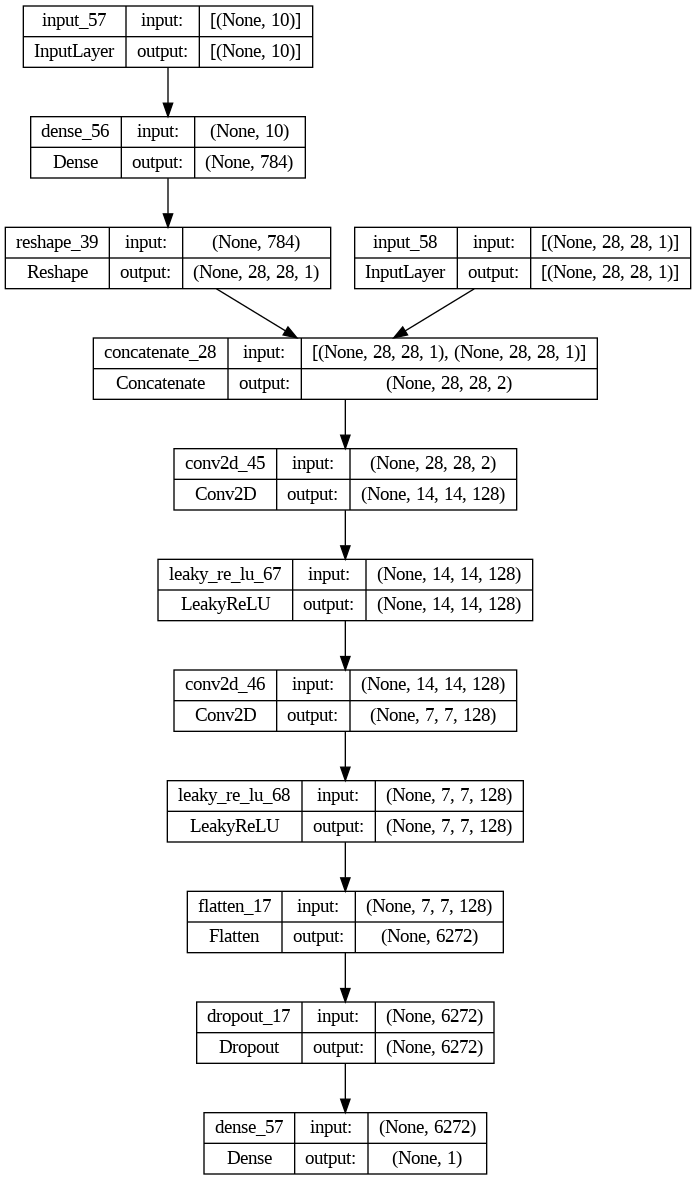

In [ ]:
define_discriminator2().summary()
keras.utils.plot_model(define_discriminator2(), "cgan_encoder.png", show_shapes=True)

In [ ]:
def define_generator2(latent_dim):

	in_label = Input(shape=(10,))
	li = Dense(7 * 7)(in_label)
	li = Reshape((7, 7, 1))(li)

	in_lat = Input(shape=(latent_dim,))     # image generator input
	gen = Dense(128 * 7 * 7)(in_lat)        # foundation for 7x7 image
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((7, 7, 128))(gen)

	merge = Concatenate()([gen, li])        # merge image gen and label input
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge) # upsample to 14x14
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)   # upsample to 28x28
	gen = LeakyReLU(alpha=0.2)(gen)
	out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)

	model = Model([in_lat, in_label], out_layer)
	return model

Model: "model_35"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_60 (InputLayer)       [(None, 100)]                0         []                            
                                                                                                  
 dense_59 (Dense)            (None, 6272)                 633472    ['input_60[0][0]']            
                                                                                                  
 input_59 (InputLayer)       [(None, 10)]                 0         []                            
                                                                                                  
 leaky_re_lu_69 (LeakyReLU)  (None, 6272)                 0         ['dense_59[0][0]']            
                                                                                           

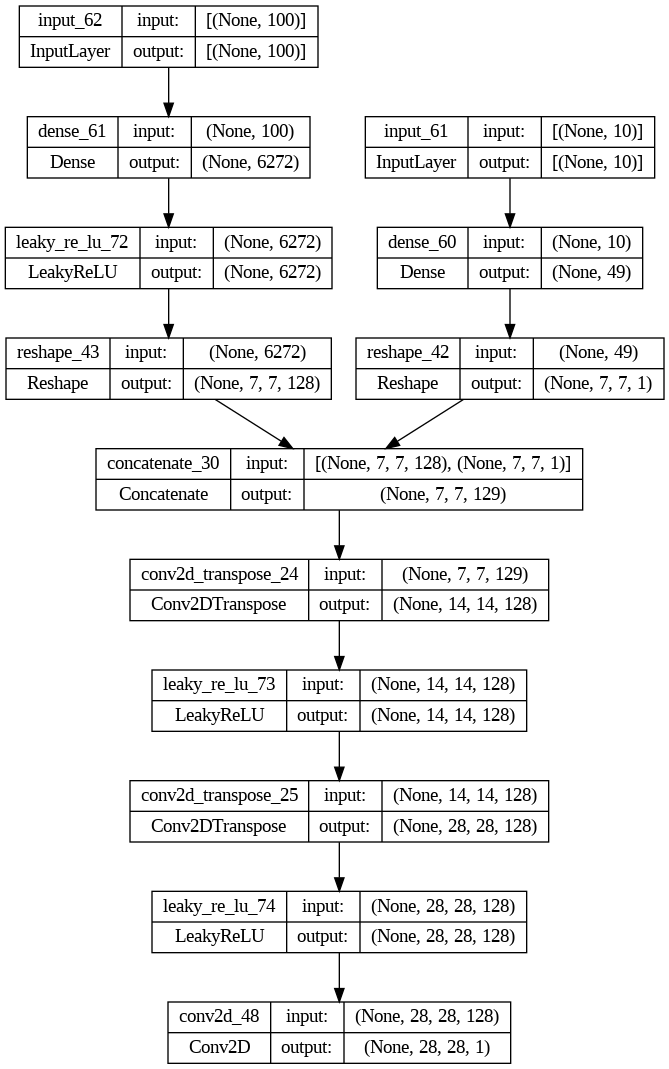

In [ ]:
define_generator2(100).summary()
keras.utils.plot_model(define_generator2(100), "cgan_decoder.png", show_shapes=True)

In [ ]:
def define_gan2(g_model, d_model):

	d_model.trainable = False
	gen_noise, gen_label = g_model.input
	gen_output = g_model.output
	gan_output = d_model([gen_output, gen_label])
	model = Model([gen_noise, gen_label], gan_output)

	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [ ]:
enc = define_discriminator2()
enc.input_shape, enc.output_shape

([(None, 28, 28, 1), (None, 10)], (None, 1))

In [ ]:
dec = define_generator2(100)
dec.input_shape, dec.input_shape

([(None, 100), (None, 10)], [(None, 100), (None, 10)])

In [ ]:
define_gan2(dec, enc).input_shape, define_gan2(dec, enc).output_shape

([(None, 100), (None, 10)], (None, 1))

In [ ]:
# load fashion mnist images
def load_real_samples():
    (trainX, trainy), (_, _) = fashion_mnist.load_data()
    X = np.expand_dims(trainX, axis=-1)
    X = X.astype('float32')
    X = (X - 127.5) / 127.5
    trainy = to_categorical(trainy, 10)
    return [X, trainy]

# select real samples
def generate_real_samples(dataset, n_samples):
	images, labels = dataset
	ix = np.random.randint(0, images.shape[0], n_samples)  # tf does not have randint
	X, labels = images[ix], labels[ix]
	y = np.ones((n_samples, 1))
	return [X, labels], y

In [ ]:
np.shape(load_real_samples()[0]), np.shape(load_real_samples()[1])

((60000, 28, 28, 1), (60000, 10))

In [ ]:
dataset = load_real_samples()
tmp = generate_real_samples(dataset, 1)
np.shape(tmp[0][0]), np.shape(tmp[0][1]), np.shape(tmp[1])

((1, 28, 28, 1), (1, 10), (1, 1))

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    x_input = np.random.randn(latent_dim * n_samples)
    z_input = x_input.reshape(n_samples, latent_dim)
    labels = np.random.randint(0, n_classes, n_samples)
    labels = to_categorical(labels, 10)
    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	images = generator.predict([z_input, labels_input])
	y = np.zeros((n_samples, 1))
	return [images, labels_input], y

In [ ]:
dataset2 = generate_latent_points(100, 1)
np.shape(dataset2[0]), np.shape(dataset2[1]),

((1, 100), (1, 10))

In [ ]:
tmp2 = generate_fake_samples(dec, 100, 1)
np.shape(tmp2[0][0]), np.shape(tmp2[0][1]), np.shape(tmp2[1])

1/1 [==============================] - 0s 35ms/step


((1, 28, 28, 1), (1, 10), (1, 1))

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=128): # n_epochs=100
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		for j in range(bat_per_epo):
			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
			d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)

			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
			y_gan = np.ones((n_batch, 1))
			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)

			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))

	g_model.save('cgan_generator.h5')

In [ ]:
latent_dim = 100
d_model = define_discriminator2()
g_model = define_generator2(latent_dim)
gan_model = define_gan2(g_model, d_model)
dataset = load_real_samples()
train(g_model, d_model, gan_model, dataset, latent_dim)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
2/2 [==============================] - 0s 12ms/step
>5, 309/468, d1=0.641, d2=0.698 g=0.791
2/2 [==============================] - 0s 14ms/step
>5, 310/468, d1=0.661, d2=0.654 g=0.813
2/2 [==============================] - 0s 8ms/step
>5, 311/468, d1=0.661, d2=0.640 g=0.863
2/2 [==============================] - 0s 14ms/step
>5, 312/468, d1=0.659, d2=0.581 g=0.871
2/2 [==============================] - 0s 10ms/step
>5, 313/468, d1=0.620, d2=0.636 g=0.897
2/2 [==============================] - 0s 5ms/step
>5, 314/468, d1=0.657, d2=0.603 g=0.836
2/2 [==============================] - 0s 12ms/step
>5, 315/468, d1=0.636, d2=0.678 g=0.775
2/2 [==============================] - 0s 11ms/step
>5, 316/468, d1=0.644, d2=0.726 g=0.716
2/2 [==============================] - 0s 14ms/step
>5, 317/468, d1=0.650, d2=0.740 g=0.725
2/2 [==============================] - 0s 9ms/step
>5, 318/468, d1=0.627, d2=0.700 g=0.790
2/2 [==============================] - 0s 11ms/

>10, 468/468, d1=0.643, d2=0.676 g=0.777


In [ ]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
import matplotlib.pyplot as plt

# generate points in latent space as input for the generator
def generate_latent_points2(latent_dim, n_samples, n_classes=10):
    x_input = randn(latent_dim * n_samples)
    z_input = x_input.reshape(n_samples, latent_dim)
    # labels = randint(0, n_classes, n_samples)
    # labels = to_categorical(labels, 10)
    return z_input

# create and save a plot of generated images
def save_plot(examples, n):
	plt.figure(figsize=(12,12))
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray')
	plt.show()

# load model
model = load_model('cgan_generator.h5')

latent_points = generate_latent_points2(100, 100)
labels = asarray([x for _ in range(10) for x in range(10)])
labels = to_categorical(labels)


In [ ]:
latent_points.shape, labels.shape, model.input_shape

((100, 100), (100, 10), [(None, 100), (None, 1)])

In [ ]:

X  = model.predict([latent_points, labels])  # generate images

X = (X + 1) / 2.0    # scale from [-1,1] to [0,1]

save_plot(X, 10)

ValueError: ignored

# Exercise

- np.array() and np.asarray():
  - if a is not an array -> both create new ones
  - if a is an array -> a new object or the exsisting object

In [ ]:
# Convert a list into an array:

a = [1, 2]
aa = np.array(a)          # a new object
aaa = np.asarray(a)       # a new object
a[0] = 7
a, aa, aaa, id(a), id(aa), id(aaa)

([7, 2],
 array([1, 2]),
 array([1, 2]),
 132291720697152,
 132291734561360,
 132291734553776)

In [ ]:
# Existing arrays

b = np.array([1, 2])
bb = np.array(b)          # a new object
bbb = np.asarray(b)       # the same object
b[0] = 7
b, bb, bbb, id(b), id(bb), id(bbb)

(array([7, 2]),
 array([1, 2]),
 array([7, 2]),
 132291734565872,
 132291734562128,
 132291734565872)